In [1]:
import os
import time

import torch
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import matplotlib.pyplot as plt

from datasets import load_dataset as load_hgf_dataset 

%matplotlib inline

In [58]:
torch.manual_seed(1661);

class Config:    
    batch_size = 128
    
    img_width = 28
    img_height = 28
    img_channels = 3
    img_flattened_size = img_width * img_height * img_channels
    
    noise_dim = 128


In [37]:
ds = load_hgf_dataset("huggingnft/cryptopunks", split="train")

In [59]:
convert_to_image = v2.Compose([
    v2.ToImage(),
    v2.Resize((Config.img_height, Config.img_width)),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])

ds.set_format('torch')
ds.set_transform(convert_to_image)
train_dataset = ds

train_loader = DataLoader(dataset=ds, batch_size=Config.batch_size, shuffle=True)

tensor(0.) tensor(0.9176)


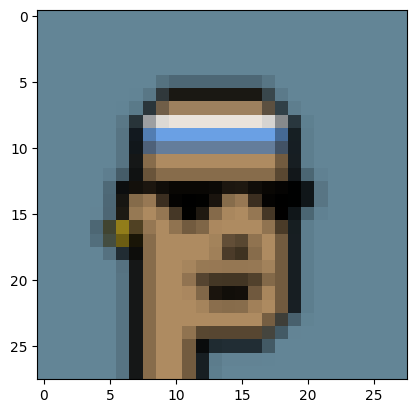

In [60]:
img = train_dataset[3616]['image']
img = (img + 1) / 2.0
print(img.min(), img.max())
plt.imshow(img.movedim(0,-1), cmap='gray');

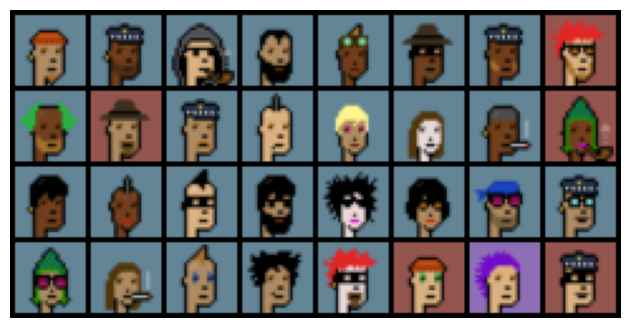

In [61]:
batch = next(iter(train_loader))
images = batch['image']
images = images[:32]

plt.figure(figsize=(8, 4))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(images, normalize=True)
            .movedim(0, -1))

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(Config.noise_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, Config.img_flattened_size),
            nn.Tanh()
        )

    def forward(self, x):
        # x has shape (B, Z_dim)

        # (B, C*W*H)
        flattened = self.blocks(x)

        # (B, C, W, H)
        img = flattened.view(
            flattened.shape[0], # Batch
            Config.img_channels,
            Config.img_width,
            Config.img_height,
        )

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Flatten(),
            nn.Linear(Config.img_flattened_size, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x has shape (B, C, W, H)

        # (B, 1)
        logits = self.blocks(x)
        return logits

In [63]:
generator = Generator()
discriminator = Discriminator()

In [77]:
optim_g = optim.Adam(
    generator.parameters(),
    lr=0.001
)

optim_d = optim.Adam(
    discriminator.parameters(),
    lr=0.001
)

loss_fn = nn.BCEWithLogitsLoss()

In [78]:
generator.train()
discriminator.train()

for epoch in range(10):
    for batch in train_loader:
        real_images = batch['image']
        batch_size = real_images.size(0)
        
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))
        
        # ===============================
        # Train discriminator
        # ===============================
        optim_d.zero_grad()
        
        # Real images
        real_logits = discriminator(real_images)
        real_loss = loss_fn(real_logits, real_labels)
        
        # Fake images
        noise = torch.randn(batch_size, Config.noise_dim)
        fake_images = generator(noise)
        fake_logits = discriminator(fake_images.detach())
        fake_loss = loss_fn(fake_logits, fake_labels)
        
        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()
        
        # ===============================
        # Train generator
        # ===============================
        optim_g.zero_grad()
        
        # Generate fake images
        fake_logits = discriminator(fake_images)
        g_loss = loss_fn(fake_logits, real_labels)
        g_loss.backward()
        optim_g.step()

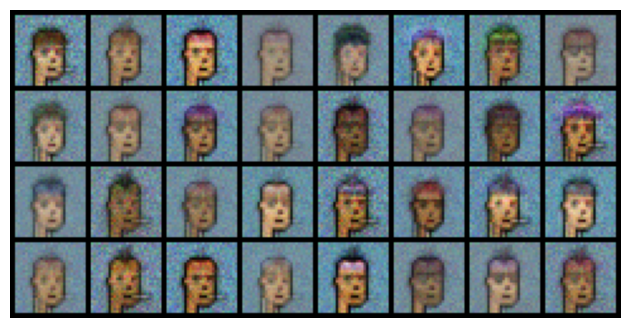

In [91]:
vis_noise = torch.randn(32, Config.noise_dim)
generator.eval()
with torch.no_grad():
    generated_images = generator(vis_noise)
    generated_images = (generated_images + 1) / 2
    # print(generated_images.min(), generated_images.max())
    
plt.figure(figsize=(8, 4))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(generated_images, normalize=True)
            .movedim(0, -1))

In [84]:
# torch.save({
#     'generator_state': generator.state_dict(),
#     'discriminator_state': discriminator.state_dict(),
# },'checkpoints/003.chk')

In [90]:
checkpoint = torch.load('checkpoints/003.chk')
generator.load_state_dict(checkpoint['generator_state'])
discriminator.load_state_dict(checkpoint['discriminator_state'])

/tmp/ipykernel_74772/3964982161.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/003.chk')


<All keys matched successfully>